## Pathways Human - MAST + fgsea

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os, sys, string

sc.set_figure_params(vector_friendly=False, fontsize=18)

import anndata
from scipy.io import mmwrite

import matplotlib.pyplot as plt
from collections import Counter

from typing import Tuple, Union, List, Dict, Callable
import os
import gzip
import shutil
import inspect
import h5py
import matplotlib

%matplotlib inline

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
%load_ext rpy2.ipython

In [6]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

#BiocManager::install("fgsea")

In [7]:
%%R
library("fgsea")
library("tidyverse")

2022-04-13 14:33:17,111 [41334] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: ── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

2022-04-13 14:33:17,117 [41334] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

2022-04-13 14:33:17,348 [41334] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: ── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter(

In [8]:
home      = "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/"
datahome  = home+ "data/"
cystichome= datahome+"Cystic_signature/"
resulthome= home+ "results/"
dehome    = resulthome+"MASTde_3xADPKD/"

gseahome  = "/Users/noamibrahimhayat/Documents/Aachen/projects/gsea/"

In [9]:
## read cluster annotation
map_df = pd.read_table(resulthome+"human_adpkd_namemap.csv", sep=",")

In [10]:
map_df.head()

,Unnamed: 0,cluster,cluster_name
0,AAACCCAGTCACTGAT_1,cluster3,3: TAL_2
1,AAACCCAGTCTGTAAC_1,cluster5,5: EC
2,AAACGAAAGCGAGTCA_1,cluster2,2: TAL_1
3,AAACGAACAGACACAG_1,cluster0,0: PC-CD/CNT
4,AAACGAACAGGCTCTG_1,cluster13,13: B-Cell


In [11]:
## get DE genes
os.system("ls " + dehome+"*.csv > " + resulthome+"mast.txt")

0

In [14]:
filenames = pd.read_table(resulthome + "mast.txt", header=None)

myfiles = filenames[0].values.tolist()

frames  = []

for filename in myfiles:
    file_id = filename.split("/")[-1].split(".csv")[0]
    print(file_id)

    tmp_df = pd.read_table(filename, sep=",")
    tmp_df["file_id"] = file_id
    frames.append(tmp_df)

MASTde_3xADPKD_B-Cell
MASTde_3xADPKD_DCT_1
MASTde_3xADPKD_DCT_2
MASTde_3xADPKD_EC
MASTde_3xADPKD_IC-A
MASTde_3xADPKD_IC-B
MASTde_3xADPKD_Mac
MASTde_3xADPKD_Mast-Cell
MASTde_3xADPKD_PC-CD.CNT
MASTde_3xADPKD_PT_1
MASTde_3xADPKD_PT_2
MASTde_3xADPKD_PT_3.PEC
MASTde_3xADPKD_PT_4
MASTde_3xADPKD_Pod
MASTde_3xADPKD_T-Cell
MASTde_3xADPKD_TAL_1
MASTde_3xADPKD_TAL_2
MASTde_3xADPKD_Unk_1
MASTde_3xADPKD_Unk_2
MASTde_3xADPKD_vSMC.Fib


In [15]:
de_df = pd.concat(frames)

In [16]:
de_df = de_df[de_df.X.isna()]

In [18]:
de_df.head(2)

,Unnamed: 0,p_val,avg_logFC,pct.1,pct.2,p_val_adj,file_id,X
0,LRP2,1.460593e-65,-2.349018,0.007,0.654,3.579037e-61,MASTde_3xADPKD_B-Cell,NaN
1,SLC17A1,2.582939e-43,-1.741585,0.002,0.385,6.329233e-39,MASTde_3xADPKD_B-Cell,NaN


In [19]:
de_df.rename(columns={'Unnamed: 0':'gene', 'file_id':'cluster_name'}, inplace=True)

In [20]:
de_df.drop(["X"],axis=1, inplace=True)

In [21]:
de_df.dtypes

gene             object
p_val           float64
avg_logFC       float64
pct.1           float64
pct.2           float64
p_val_adj       float64
cluster_name     object
dtype: object

In [22]:
#de_df.sort_values(by=["cluster_name", "avg_logFC"], ascending=[True, False]).\
#to_excel(resulthome+"Human_Kidney_DE_ADKPD_vs_Control.xlsx")

In [23]:
de_count_df = de_df[["gene", "cluster_name"]].groupby("cluster_name")["gene"].count().reset_index()

<Figure size 216x144 with 0 Axes>

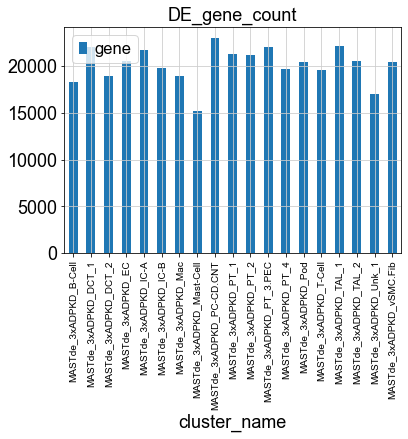

In [25]:
if 1:
    f = plt.figure(figsize = (3,2))
    ax = de_count_df.plot.bar(x='cluster_name', y='gene', rot=90)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    #ax.set_ylim(0,.4)
    ax.set_title('DE_gene_count')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, size=10)
    #plt.savefig('Kidney_ADPKD_Human3X_MAST_DE_Counts_all.pdf', bbox_inches='tight')

In [26]:
de_sig_df   = de_df[de_df["p_val_adj"]<0.01]
de_count_df = de_sig_df[["gene", "cluster_name"]].groupby("cluster_name")["gene"].count().reset_index()

<Figure size 216x144 with 0 Axes>

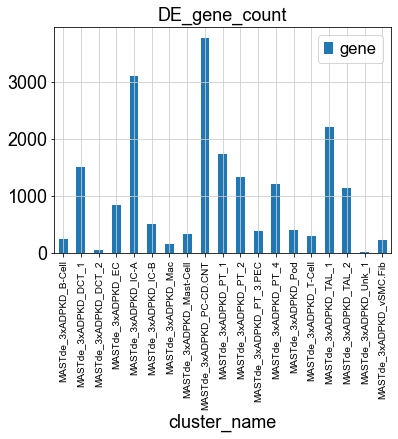

In [27]:
if 1:
    f = plt.figure(figsize = (3,2))
    ax = de_count_df.plot.bar(x='cluster_name', y='gene', rot=90)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    #ax.set_ylim(0,.4)
    ax.set_title('DE_gene_count')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, size=10)
    plt.savefig('Kidney_ADPKD_Human3X_MAST_DE_Counts_FDR.pdf', bbox_inches='tight')

In [28]:
myclusters = de_df["cluster_name"].unique().tolist()

In [29]:
os.system("rm " + resulthome + "human_adpkd_dataset_logFC_*.rnk")

0

In [30]:
for this_cluste in myclusters:
    de_speific = de_df[de_df["cluster_name"]==this_cluste]

    this_cluste = this_cluste.replace(' ', '')
    this_cluste = this_cluste.replace('/', '_')
    this_cluste = this_cluste.replace(':', '_')

    if this_cluste == "MASTde_3xADPKD_Unk_1": continue
    print(this_cluste)

    # create a rnk file
    rnk = pd.DataFrame({'gene': de_speific['gene'].values,
                        'logFC': de_speific['avg_logFC'].values})

    rnk.sort_values(by="logFC", ascending=False, inplace=True)

    rnk.to_csv(resulthome + 'human_adpkd_dataset_logFC_'+this_cluste+'_de.rnk', 
               sep='\t', index=False, header=['# gene', 'logFC'])

MASTde_3xADPKD_B-Cell
MASTde_3xADPKD_DCT_1
MASTde_3xADPKD_DCT_2
MASTde_3xADPKD_EC
MASTde_3xADPKD_IC-A
MASTde_3xADPKD_IC-B
MASTde_3xADPKD_Mac
MASTde_3xADPKD_Mast-Cell
MASTde_3xADPKD_PC-CD.CNT
MASTde_3xADPKD_PT_1
MASTde_3xADPKD_PT_2
MASTde_3xADPKD_PT_3.PEC
MASTde_3xADPKD_PT_4
MASTde_3xADPKD_Pod
MASTde_3xADPKD_T-Cell
MASTde_3xADPKD_TAL_1
MASTde_3xADPKD_TAL_2
MASTde_3xADPKD_vSMC.Fib


In [31]:
os.system("ls " + resulthome + "human_adpkd_dataset_logFC_*.rnk > "+resulthome + "tmp.txt")

0

In [32]:
os.system("rm " + resulthome + "human_adpkd_dataset_logFC_*gsea")

256

In [33]:
filenames = pd.read_table(resulthome + "tmp.txt", header=None)

myfiles = filenames[0].values.tolist()

frames = []

for filename in myfiles:
    file_id = filename.split("/")[-1].split(".rnk")[0]
    if file_id == "human_adpkd_dataset_logFC_MASTde_3xADPKD_Unk_1_de": continue
    print(file_id)

    tmp_df = pd.read_table(filename, sep="\t")
    
    tmp_df["file_id"] = file_id
    frames.append(tmp_df)

human_adpkd_dataset_logFC_MASTde_3xADPKD_B-Cell_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_DCT_1_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_DCT_2_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_EC_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_IC-A_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_IC-B_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_Mac_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_Mast-Cell_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_PC-CD.CNT_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_PT_1_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_PT_2_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_PT_3.PEC_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_PT_4_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_Pod_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_T-Cell_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_TAL_1_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_TAL_2_de
human_adpkd_dataset_logFC_MASTde_3xADPKD_vSMC.Fib_de


In [34]:
mydf = pd.concat(frames)

In [35]:
mydf.head(2)

,# gene,logFC,file_id
0,IGKC,2.843295,human_adpkd_dataset_logFC_MASTde_3xADPKD_B-Cel...
1,MT1X,2.833102,human_adpkd_dataset_logFC_MASTde_3xADPKD_B-Cel...


In [36]:
%%R -i myfiles

for (rnk.file in myfiles){
    #print(rnk.file)
    
    gmt.file <- "/Users/noamibrahimhayat/Documents/Aachen/projects/gsea/c2.cp.kegg.v7.4.symbols.gmt"
    
    z <- strsplit(gmt.file, "/")[[1]][8]
    out_suffix <- strsplit(z, "symbols.gmt")[[1]]
    print(out_suffix)
    
    out.file  <- paste0(strsplit(rnk.file, ".rnk"), "_", out_suffix, "gsea")
    print(out.file)
    
    # load ranks
    ranks <- read.table(rnk.file, header=FALSE, colClasses = c("character", "numeric"))
    ranks <- deframe(ranks)  # needs tidyverse
    #print(head(ranks, 20))

    ## pathways
    pathways <- gmtPathways(gmt.file)
    #print(head(pathways))

    # run fGSEA
    fgseaRes <- fgsea(pathways, ranks, minSize=15, maxSize=500, nperm=10000)

    fgseaResTidy <- fgseaRes %>%
      as_tibble() %>%
      arrange(desc(NES))
    
    ## Save
    library("data.table")
    fwrite(fgseaResTidy, file =out.file)
    }

[1] "c2.cp.kegg.v7.4."
[1] "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/human_adpkd_dataset_logFC_MASTde_3xADPKD_B-Cell_de_c2.cp.kegg.v7.4.gsea"


2022-04-13 14:35:54,451 [41334] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: data.table 1.14.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

2022-04-13 14:35:54,454 [41334] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: **********
This installation of data.table has not detected OpenMP support. It should still work but in single-threaded mode.
This is a Mac. Please read https://mac.r-project.org/openmp/. Please engage with Apple and ask them for support. Check r-datatable.com for updates, and our Mac instructions here: https://github.com/Rdatatable/data.table/wiki/Installation. After several years of many reports of installation problems on Mac, it's time to gingerly point out that there have been no similar problems on Windows or Linux.
**********

2022-04-13 14:35:54,459 [41334] WARNING  rpy2.rinterface_lib.callbacks:123: [JupyterRequire] R[write to console]: 
Attaching package: ‘data.table’

[1] "c2.cp.kegg.v7.4."
[1] "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/human_adpkd_dataset_logFC_MASTde_3xADPKD_DCT_1_de_c2.cp.kegg.v7.4.gsea"
[1] "c2.cp.kegg.v7.4."
[1] "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/human_adpkd_dataset_logFC_MASTde_3xADPKD_DCT_2_de_c2.cp.kegg.v7.4.gsea"
[1] "c2.cp.kegg.v7.4."
[1] "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/human_adpkd_dataset_logFC_MASTde_3xADPKD_EC_de_c2.cp.kegg.v7.4.gsea"
[1] "c2.cp.kegg.v7.4."
[1] "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/human_adpkd_dataset_logFC_MASTde_3xADPKD_IC-A_de_c2.cp.kegg.v7.4.gsea"
[1] "c2.cp.kegg.v7.4."
[1] "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/human_adpkd_dataset_logFC_MASTde_3xADPKD_IC-B_de_c2.cp.kegg.v7.4.gsea"
[1] "c2.cp.kegg.v7.4."
[1] "/Users/noamibrahimhayat/Documents/Aachen/projects/kidney_organoids/results/human_adpkd_dataset_logFC_M

In [37]:
os.system("ls " + resulthome + "human_adpkd_dataset_logFC_*gsea > "+resulthome + "tmp.txt")

0

In [39]:
filenames = pd.read_table(resulthome + "tmp.txt", header=None)
myfiles   = filenames[0].values.tolist()

padj_cutoff = 0.05

frames = []

for filename in myfiles:
    file_id      = filename.split("/")[-1].split(".rnk")[0]
    cluster_name = file_id.split("logFC_")[1].split("_de")[0]
    
    sig_file = filename.split(".gsea")[0]+"_significant.gsea"
    
    gsea = pd.read_csv(filename)
    
    gsea["cluster_name"] = cluster_name
    gsea.sort_values(by='NES', ascending=False)
    
    gsea[(gsea['padj'] < padj_cutoff)].sort_values(by='NES', ascending=False).to_csv(sig_file)
    
    print(file_id, gsea[(gsea['padj'] < padj_cutoff)].shape[0])

    frames.append(gsea[(gsea['padj'] < padj_cutoff)])#.sort_values(by='NES', ascending=False).head(10))

human_adpkd_dataset_logFC_MASTde_3xADPKD_B-Cell_de_c2.cp.kegg.v7.4.gsea 14
human_adpkd_dataset_logFC_MASTde_3xADPKD_DCT_1_de_c2.cp.kegg.v7.4.gsea 11
human_adpkd_dataset_logFC_MASTde_3xADPKD_DCT_2_de_c2.cp.kegg.v7.4.gsea 12
human_adpkd_dataset_logFC_MASTde_3xADPKD_EC_de_c2.cp.kegg.v7.4.gsea 12
human_adpkd_dataset_logFC_MASTde_3xADPKD_IC-A_de_c2.cp.kegg.v7.4.gsea 0
human_adpkd_dataset_logFC_MASTde_3xADPKD_IC-B_de_c2.cp.kegg.v7.4.gsea 1
human_adpkd_dataset_logFC_MASTde_3xADPKD_Mac_de_c2.cp.kegg.v7.4.gsea 0
human_adpkd_dataset_logFC_MASTde_3xADPKD_Mast-Cell_de_c2.cp.kegg.v7.4.gsea 10
human_adpkd_dataset_logFC_MASTde_3xADPKD_PC-CD.CNT_de_c2.cp.kegg.v7.4.gsea 9
human_adpkd_dataset_logFC_MASTde_3xADPKD_PT_1_de_c2.cp.kegg.v7.4.gsea 10
human_adpkd_dataset_logFC_MASTde_3xADPKD_PT_2_de_c2.cp.kegg.v7.4.gsea 22
human_adpkd_dataset_logFC_MASTde_3xADPKD_PT_3.PEC_de_c2.cp.kegg.v7.4.gsea 16
human_adpkd_dataset_logFC_MASTde_3xADPKD_PT_4_de_c2.cp.kegg.v7.4.gsea 41
human_adpkd_dataset_logFC_MASTde_3xADPKD

In [40]:
select_gsea_df = pd.concat(frames)

In [41]:
select_gsea_df.head()

,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge,cluster_name
0,KEGG_RIBOSOME,0.000234,0.010110,0.684862,2.215477,0,81,RPS27A|RPL13|RPL28|RPS8|RPL21|RPS4X|RPL8|RPS6|...,MASTde_3xADPKD_B-Cell
1,KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY,0.000228,0.010110,0.585572,1.850907,0,69,NFKB1|NFATC1|VAV1|NFKBIA|LYN|PRKCB|NFATC2|MALT...,MASTde_3xADPKD_B-Cell
2,KEGG_PROTEIN_EXPORT,0.000860,0.017742,0.722989,1.834210,3,23,SRP54|SEC63|SEC62|SEC61A1|IMMP1L|SRP9|IMMP2L|S...,MASTde_3xADPKD_B-Cell
3,KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY,0.000711,0.016749,0.541754,1.796714,2,94,NFKB1|NFATC1|PTPRC|VAV1|NFKBIA|MAP3K8|NFATC2|M...,MASTde_3xADPKD_B-Cell
4,KEGG_PROSTATE_CANCER,0.000703,0.016749,0.546946,1.769327,2,81,NFKB1|HSP90AB1|BCL2|NFKBIA|CREB3L2|CREB1|KRAS|...,MASTde_3xADPKD_B-Cell


In [42]:
mygrp = select_gsea_df.groupby("cluster_name")

In [43]:
results_frame = []
for name, myg in mygrp:
    print(name, myg.shape[0], myg[myg["NES"]>0].shape[0])
    #results_frame.append(myg[myg["NES"]>0])
    results_frame.append(myg)

MASTde_3xADPKD_B-Cell 14 11
MASTde_3xADPKD_DCT_1 11 7
MASTde_3xADPKD_DCT_2 12 7
MASTde_3xADPKD_EC 12 8
MASTde_3xADPKD_IC-B 1 0
MASTde_3xADPKD_Mast-Cell 10 10
MASTde_3xADPKD_PC-CD.CNT 9 9
MASTde_3xADPKD_PT_1 10 5
MASTde_3xADPKD_PT_2 22 16
MASTde_3xADPKD_PT_3.PEC 16 16
MASTde_3xADPKD_PT_4 41 25
MASTde_3xADPKD_T-Cell 11 10
MASTde_3xADPKD_TAL_1 19 11
MASTde_3xADPKD_TAL_2 10 7
MASTde_3xADPKD_vSMC.Fib 18 11


In [45]:
results_df = pd.concat(results_frame)[["cluster_name", "pathway", "NES", "leadingEdge", "pval", "padj"]]#.head(35)

In [268]:
results_df.to_csv(resulthome+"kegg_all_celltypes_human_pathways.txt")

## READ again

In [204]:
results_df = pd.read_table(resulthome+"kegg_all_celltypes_human_pathways.txt", sep=",")

In [46]:
results_df.shape
#results_df.drop(["Unnamed: 0"], axis=1, inplace=True)

(216, 6)

In [47]:
results_df.head()

,cluster_name,pathway,NES,leadingEdge,pval,padj
0,MASTde_3xADPKD_B-Cell,KEGG_RIBOSOME,2.215477,RPS27A|RPL13|RPL28|RPS8|RPL21|RPS4X|RPL8|RPS6|...,0.000234,0.010110
1,MASTde_3xADPKD_B-Cell,KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY,1.850907,NFKB1|NFATC1|VAV1|NFKBIA|LYN|PRKCB|NFATC2|MALT...,0.000228,0.010110
2,MASTde_3xADPKD_B-Cell,KEGG_PROTEIN_EXPORT,1.834210,SRP54|SEC63|SEC62|SEC61A1|IMMP1L|SRP9|IMMP2L|S...,0.000860,0.017742
3,MASTde_3xADPKD_B-Cell,KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY,1.796714,NFKB1|NFATC1|PTPRC|VAV1|NFKBIA|MAP3K8|NFATC2|M...,0.000711,0.016749
4,MASTde_3xADPKD_B-Cell,KEGG_PROSTATE_CANCER,1.769327,NFKB1|HSP90AB1|BCL2|NFKBIA|CREB3L2|CREB1|KRAS|...,0.000703,0.016749


In [48]:
plot_df = results_df[["cluster_name", "pathway", "NES"]]\
    .pivot(index='cluster_name', columns='pathway', values='NES').fillna(0)

In [49]:
results_df.head(2)

,cluster_name,pathway,NES,leadingEdge,pval,padj
0,MASTde_3xADPKD_B-Cell,KEGG_RIBOSOME,2.215477,RPS27A|RPL13|RPL28|RPS8|RPL21|RPS4X|RPL8|RPS6|...,0.000234,0.01011
1,MASTde_3xADPKD_B-Cell,KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY,1.850907,NFKB1|NFATC1|VAV1|NFKBIA|LYN|PRKCB|NFATC2|MALT...,0.000228,0.01011


In [50]:
plot_df.shape

(15, 70)

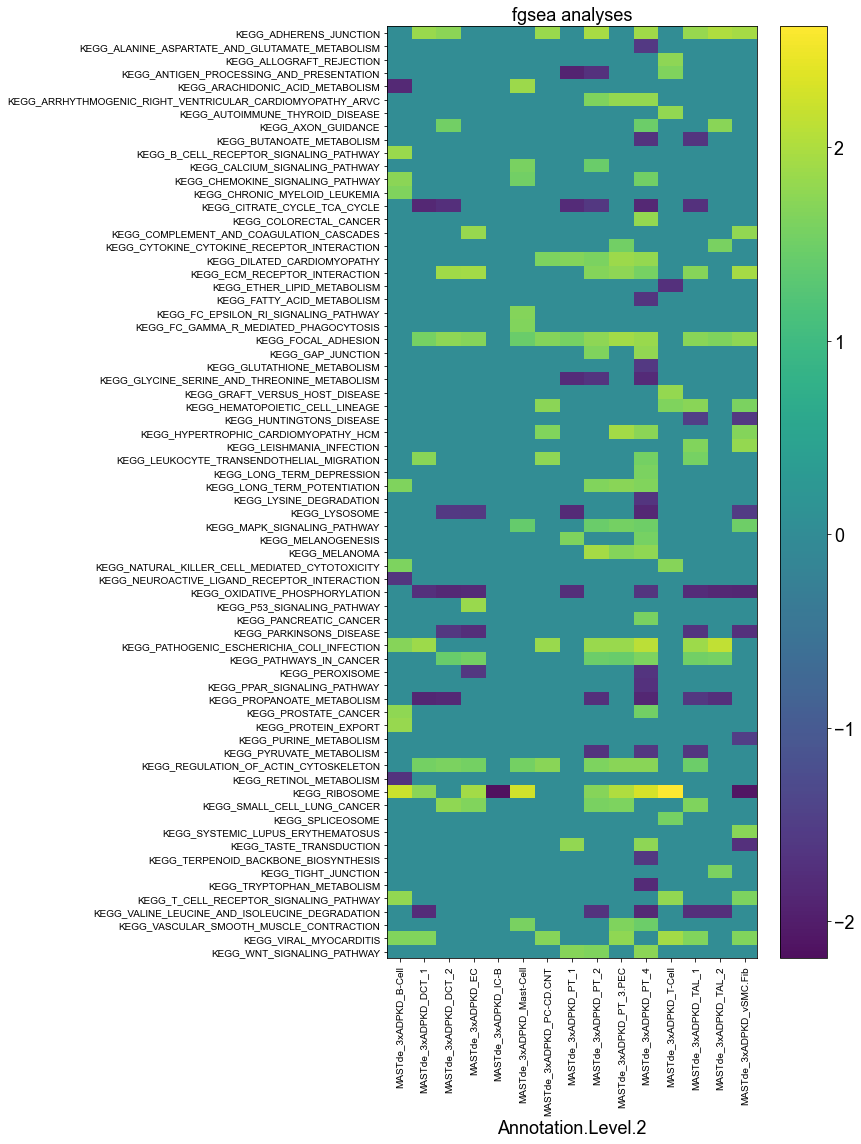

In [51]:
## Plot scores

mat = plot_df.to_numpy()

plt.figure(figsize=(12, 16))

dp = plt.imshow(np.transpose(mat),cmap=plt.cm.get_cmap('viridis'), \
          alpha=0.94,interpolation='antialiased', aspect='auto')#,

plt.yticks(ticks=range(mat.shape[1]), labels=[s[0:] for s in plot_df.columns], rotation=0,fontsize=10)
plt.xticks(ticks=range(mat.shape[0]), labels=[s[0:] for s in plot_df.index], rotation=90, fontsize=10)
plt.xlabel('Annotation.Level.2')

plt.grid(None)   #<---- this should remove that white grid
#plt.grid(color='w', linewidth=2)
#plt.grid(which='minor', color='w', linestyle='-', linewidth=12)

plt.colorbar()
plt.title('fgsea analyses')
plt.tight_layout()
plt.savefig(resulthome+ "adpkd_org_human_kegg_fgsea_selected.pdf")